In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import math
import sys
from sklearn.model_selection import train_test_split


# Importing and combining many datasets we've collected

In [2]:
data1 = pd.read_csv("Data-4-30.csv",header=None).to_numpy()
data2 = pd.read_csv("Data-4-30-Daeyoo.csv",header=None).to_numpy()
data3 = pd.read_csv("Data-Ege-1.csv",header=None).to_numpy()
data4 = pd.read_csv("Data-Ege-2.csv",header=None).to_numpy()
data5 = pd.read_csv("Data-Daeyoo-1.csv",header=None).to_numpy()

In [3]:
data2.shape

(1452, 4)

In [4]:
full_data = np.append(data1,data2,axis=0)
full_data = np.append(full_data,data3,axis=0)
full_data = np.append(full_data,data4,axis=0)
full_data = np.append(full_data,data5,axis=0)

In [5]:
full_data.shape

(8065, 4)

## The above code is to calculate how many timesteps an average single walk takes

In [6]:
inside_walking = False
total = 0
walkingAmt = 0


for i,sample in enumerate(full_data[:,3]):
    
    if(sample == 1 and inside_walking == False):
        #print("Start: "+str(i))
        inside_walking = True
        total = total + 1
    
    if(sample == 1 and inside_walking == True):
        total = total + 1
    
    if(sample == 0 and inside_walking == True):
        #print("End: "+str(i))
        inside_walking = False
        walkingAmt = walkingAmt + 1
        
print(np.sum(full_data[:,3])/walkingAmt)
        

15.395973154362416


### Interactive plot of Z-axis and Y 

Red = Walking, Blue = Not Walking


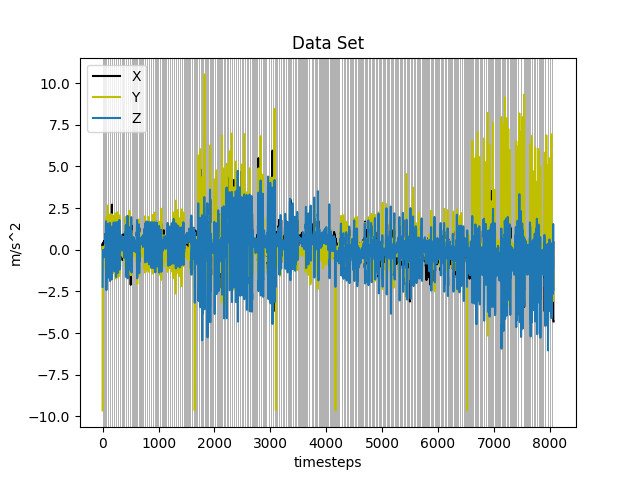

In [10]:
#%matplotlib widget
#Uncomment above code to make it interactive

print("Red = Walking, Blue = Not Walking")
plt.figure()

#figsize=(12,10)
testY = full_data[:,3]


for i in range(len(full_data)):
    if(testY[i] == 1):
        plt.axvspan(i-1, i, facecolor='w', alpha=0.3)
    else:
        plt.axvspan(i-1, i, facecolor='k', alpha=0.3)


plt.plot(full_data[:,0]-np.mean(full_data[:,0]),color="k",label="X")
plt.plot(full_data[:,1]-np.mean(full_data[:,1]),color="y",label="Y")
plt.plot(full_data[:,2]-np.mean(full_data[:,2]),label="Z")
plt.ylabel("m/s^2")
plt.xlabel("timesteps")
plt.title("Data Set")
#plt.plot(full_data[:,3],label="Walking?")
plt.legend()

# Seperate dataset into samples

### Sample length refers to how many timesteps a single sample will be when dataset is splitted

In [12]:
def Prepare_Data(sampleLength,data):
    
    Y = data[:,3]
    X = data[:,0:3]
    
    
    Splitted_X = np.array(np.split(X, sampleLength))
    Splitted_Y = np.array(np.split(Y, np.ma.size(Y,axis=0)/sampleLength))
    
    
    
    finalX = np.reshape(Splitted_X,(np.ma.size(Splitted_X, axis=1),sampleLength,3))
    
    
    
    Output = np.round(np.sum(Splitted_Y,axis=1)/sampleLength)
    
    
    
    return finalX,Output

# Define Simple Vanilla Neural Network 

In [21]:
def my_model(n):

    input_1 = keras.Input(shape = (n,))

    dense_1= Dense(20,activation = 'relu')(input_1)
    dense_2= Dense(20,activation = 'relu')(dense_1)
    dense_3= Dense(1,activation = 'sigmoid')(dense_2)

    model = keras.Model(inputs = input_1, outputs = dense_3)
    return model

# Training

In [22]:
plot_0=[]
plot_1=[]
plot_2=[]

plot_x=[]
for i in range(1,20):
    
    
    
    print("--------------------------------------------------------------")
    print(i)
    
    
    finalX , Output = Prepare_Data(i,full_data[0: math.floor(np.ma.size(full_data,axis=0)/i)*i,:])
    
    #print("1s: "+str(np.sum(Output,axis=0)/np.ma.size(Output, axis=0)))
    #print("0s: "+str((np.ma.size(Output, axis=0)-np.sum(Output,axis=0))/np.ma.size(Output, axis=0)))
    
    
    
    X = finalX[:,:,0]
    Y = finalX[:,:,1]
    Z = finalX[:,:,2]
    
    
    
    model0 = my_model(i)
    
    model0.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    
    model1 = my_model(i)
    
    model1.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    
    model2 = my_model(i)
    
    model2.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    
    X_trainX, X_testX, y_trainX, y_testX = train_test_split(X, Output, test_size=0.33, random_state=42)
    X_trainY, X_testY, y_trainY, y_testY = train_test_split(Y, Output, test_size=0.33, random_state=42)
    X_trainZ, X_testZ, y_trainZ, y_testZ = train_test_split(Z, Output, test_size=0.33, random_state=42)
    
    history_train0 = model0.fit(X_trainX,y_trainX,epochs = 10,validation_split=0.3,validation_data=(X_testX,y_testX),batch_size=16,verbose=0)
    history_train1 = model1.fit(X_trainY,y_trainY,epochs = 10,validation_split=0.3,validation_data=(X_testY,y_testY),batch_size=16,verbose=0)
    history_train2 = model2.fit(X_trainZ,y_trainZ,epochs = 10,validation_split=0.3,validation_data=(X_testZ,y_testZ),batch_size=16,verbose=0)
    
    print("X axis validation accuracy: "+str(history_train0.history['val_accuracy'][-1]))
    print("Y axis validation accuracy: "+str(history_train1.history['val_accuracy'][-1]))
    print("Z axis validation accuracy: "+str(history_train2.history['val_accuracy'][-1]))
    
    
    plot_x.append(i)
    
    plot_0.append(history_train0.history['val_accuracy'][-1])
    plot_1.append(history_train1.history['val_accuracy'][-1])
    plot_2.append(history_train2.history['val_accuracy'][-1])
    
    
    
    
    

--------------------------------------------------------------
1
X axis validation accuracy: 0.7433682680130005
Y axis validation accuracy: 0.7273288369178772
Z axis validation accuracy: 0.7970388531684875
--------------------------------------------------------------
2
X axis validation accuracy: 0.7755857110023499
Y axis validation accuracy: 0.7755857110023499
Z axis validation accuracy: 0.7866830825805664
--------------------------------------------------------------
3
X axis validation accuracy: 0.7925925850868225
Y axis validation accuracy: 0.7722222208976746
Z axis validation accuracy: 0.8037037253379822
--------------------------------------------------------------
4
X axis validation accuracy: 0.7684729099273682
Y axis validation accuracy: 0.7733989953994751
Z axis validation accuracy: 0.807881772518158
--------------------------------------------------------------
5
X axis validation accuracy: 0.7530864477157593
Y axis validation accuracy: 0.7222222089767456
Z axis validation 

Text(0.5, 1.0, 'Training Neural Network Models With Different Time Lengths')

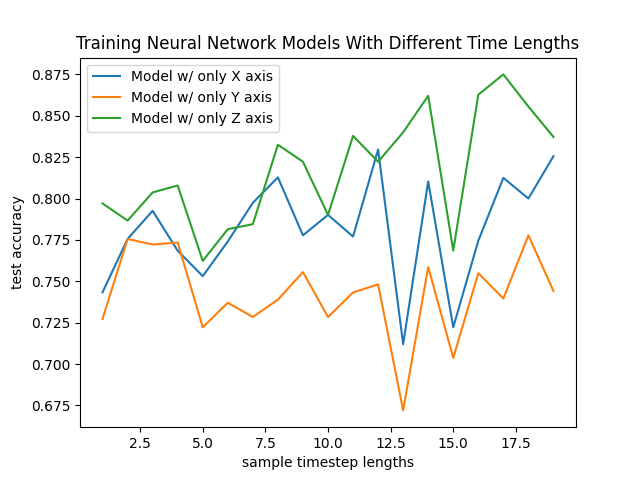

In [26]:
fig = plt.figure()
plt.plot(plot_x,plot_0,label="Model w/ only X axis")
plt.plot(plot_x,plot_1,label="Model w/ only Y axis")
plt.plot(plot_x,plot_2,label="Model w/ only Z axis")
plt.legend()
plt.ylabel("test accuracy")
plt.xlabel("sample timestep lengths")
plt.title("Training Neural Network Models With Different Time Lengths")

Epoch 1/30
34/34 [==============================] - 1s 6ms/step - loss: 0.8348 - accuracy: 0.3278 - val_loss: 0.6484 - val_accuracy: 0.8120
Epoch 2/30
34/34 [==============================] - 0s 3ms/step - loss: 0.5896 - accuracy: 0.8185 - val_loss: 0.5367 - val_accuracy: 0.7932
Epoch 3/30
34/34 [==============================] - 0s 4ms/step - loss: 0.5396 - accuracy: 0.8037 - val_loss: 0.5165 - val_accuracy: 0.7970
Epoch 4/30
34/34 [==============================] - 0s 4ms/step - loss: 0.5251 - accuracy: 0.8111 - val_loss: 0.5054 - val_accuracy: 0.8045
Epoch 5/30
34/34 [==============================] - 0s 4ms/step - loss: 0.5132 - accuracy: 0.8204 - val_loss: 0.4978 - val_accuracy: 0.8120
Epoch 6/30
34/34 [==============================] - 0s 4ms/step - loss: 0.5021 - accuracy: 0.8259 - val_loss: 0.4904 - val_accuracy: 0.8158
Epoch 7/30
34/34 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.8278 - val_loss: 0.4819 - val_accuracy: 0.8233
Epoch 8/30
34/34 [==

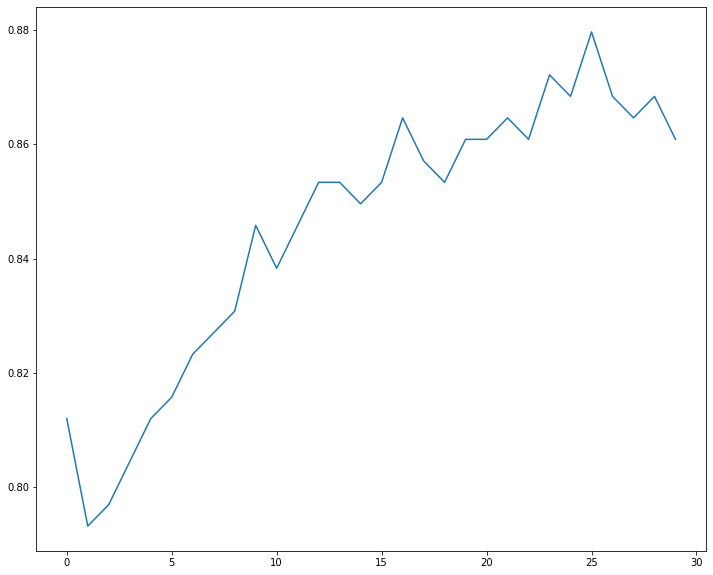

In [11]:
i = 10
finalX , Output = Prepare_Data(i,full_data[0: math.floor(np.ma.size(full_data,axis=0)/i)*i,:])
    

X = finalX[:,:,0]
Y = finalX[:,:,1]
Z = finalX[:,:,2]

X_train, X_test, y_train, y_test = train_test_split(Z, Output, test_size=0.33, random_state=42)

modelZ = my_model(i)

modelZ.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

history_train = modelZ.fit(X_train,y_train,epochs = 30,validation_data=(X_test,y_test),batch_size=16,verbose=1)
#modelZ.save('model_Z')

fig = plt.figure(figsize=(12,10))
plt.plot(history_train.history['val_accuracy'])

# GDA

In [14]:
def GDA_estimator(X_train, y_train, d, class_1, class_2):
    
    phi = np.mean(y_train)
    mu_0 = np.sum((y_train==class_2).reshape(-1, 1)*X_train, axis=0) / np.sum(y_train==class_2)
    mu_1 = np.sum((y_train==class_1).reshape(-1, 1)*X_train, axis=0) / np.sum(y_train==class_1)
    sigma_kk = np.mean(np.concatenate((np.square(X_train[(y_train==class_2).ravel()]-mu_0.reshape(1, -1)), np.square(X_train[(y_train==class_1).ravel()]-mu_1.reshape(1, -1))), axis=0), axis=0)
    sigma = np.eye(d)
    for i in range(d):
        sigma[i][i] = sigma_kk[i]
    
    return phi, mu_0, mu_1, sigma

In [15]:
def GDA_Predict(data, d, mu_1, mu_0, sigma, phi, class1, class2):
    
    y_GDA_1 = 1. / (np.power(np.power(2 * np.pi, d) * np.abs(np.linalg.det(sigma + np.eye(d) * 0.001)), 0.5)) * np.exp(-0.5 * (data - mu_1).reshape(1, -1).dot(np.linalg.inv(sigma + np.eye(d) * 0.001)).dot((data - mu_1).reshape(1, -1).T)) * phi
    y_GDA_0 = 1. / (np.power(np.power(2 * np.pi, d) * np.abs(np.linalg.det(sigma + np.eye(d) * 0.001)), 0.5)) * np.exp(-0.5 * (data - mu_0).reshape(1, -1).dot(np.linalg.inv(sigma + np.eye(d) * 0.001)).dot((data - mu_0).reshape(1, -1).T)) * (1-phi)
    
    if y_GDA_1 >= y_GDA_0:
        return class1
    else:
        return class0



In [16]:
def GDA_output(X_test, y_test, d, mu_1, mu_0, sigma, phi, class1, class2):
    
    y_GDA = []
    
    for data in X_test:
        y_GDA_1 = 1. / (np.power(np.power(2 * np.pi, d) * np.abs(np.linalg.det(sigma + np.eye(d) * 0.001)), 0.5)) * np.exp(-0.5 * (data - mu_1).reshape(1, -1).dot(np.linalg.inv(sigma + np.eye(d) * 0.001)).dot((data - mu_1).reshape(1, -1).T)) * phi
        y_GDA_0 = 1. / (np.power(np.power(2 * np.pi, d) * np.abs(np.linalg.det(sigma + np.eye(d) * 0.001)), 0.5)) * np.exp(-0.5 * (data - mu_0).reshape(1, -1).dot(np.linalg.inv(sigma + np.eye(d) * 0.001)).dot((data - mu_0).reshape(1, -1).T)) * (1-phi)

        if y_GDA_1 >= y_GDA_0:
            y_GDA.append(class1)
        else:
            y_GDA.append(class2)
    
    return np.array(y_GDA).reshape(-1, 1)

In [17]:
def evaluate_error(y_test, y_hat):
    
    error = np.mean(np.abs(y_test-y_hat.T[0]))
    
    return error

In [18]:
plot_x=[]
plot_y=[]

for i in range(1,20):
    finalX , Output = Prepare_Data(i,full_data[0: math.floor(np.ma.size(full_data,axis=0)/i)*i,:])
    Z = finalX[:,:,2]
    X_train, X_test, y_train, y_test = train_test_split(finalX[:,:,2], Output, test_size=0.33, random_state=42)
    phi, mu_0, mu_1, sigma = GDA_estimator(X_train, y_train, i, 0, 1)
    y_GDA = GDA_output(X_test, y_test, i, mu_1, mu_0, sigma, phi, 0, 1)
    GDA_error = evaluate_error(y_test, y_GDA)
    
    plot_x.append(i)
    plot_y.append(GDA_error)
    
    print(GDA_error)
    

0.70473328324568
0.7220135236664162
0.704954954954955
0.7327327327327328
0.6941838649155723
0.6283783783783784
0.6351706036745407
0.5645645645645646
0.581081081081081
0.5827067669172933
0.47520661157024796
0.3063063063063063
0.3463414634146341
0.3717277486910995
0.33707865168539325
0.20359281437125748
0.27388535031847133
0.35135135135135137
0.22142857142857142


Text(0.5, 1.0, 'Training GDA Models with different time lengths')

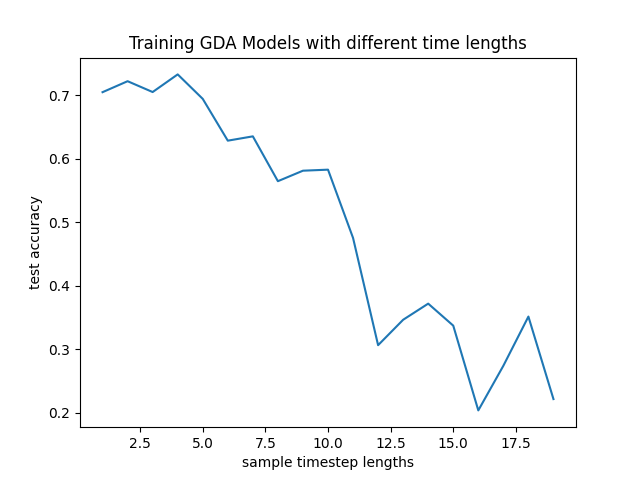

In [19]:
plt.figure()
plt.plot(plot_x,plot_y)

plt.ylabel("test accuracy")
plt.xlabel("sample timestep lengths")
plt.title("Training GDA Models with different time lengths")